In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd

%jsroot on
# %matplotlib qt
%matplotlib inline

In [23]:
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
mpl.rc('font', **{'family':'serif', 'serif':['Computer Modern Roman']})
params = {'backend': 'pdf',
          'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'text.usetex': True,
          'figure.figsize': (5,5),
          'axes.unicode_minus': True}
mpl.rcParams.update(params)

In [37]:
df = pd.DataFrame(columns=['radius', 
                           'number', 
                           'distance_primary_mean', 
                           'distance_primary_std', 
                           'distance_primary_sigma_1', 
                           'distance_primary_sigma_2', 
                           'distance_primary_sigma_3', 
                           'distance_initial_mean', 
                           'distance_initial_std', 
                           'distance_initial_sigma_1', 
                           'distance_initial_sigma_2', 
                           'distance_initial_sigma_3'
                          ]
                 )

rows = [
[0.00, 0.00, 77.89, 143.02, 40.86, 367.74, 994.26, 360.43, 527.48, 213.03, 1630.99, 2659.01],
[3.00, 1.00, 40.25, 61.68, 27.45, 155.55, 475.80, 189.39, 262.59, 113.87, 766.67, 1760.07],
[3.00, 2.00, 32.75, 42.05, 28.60, 108.68, 291.72, 149.26, 187.15, 126.32, 546.26, 1302.14],
[3.00, 3.00, 30.45, 36.67, 27.84, 88.16, 259.84, 133.33, 157.21, 117.68, 430.60, 1115.10],
[3.00, 4.00, 29.22, 33.83, 27.78, 78.71, 240.76, 124.72, 141.20, 118.20, 352.82, 1037.13],
[3.00, 5.00, 28.04, 31.01, 27.78, 74.08, 226.87, 118.13, 129.43, 117.04, 316.15, 979.84],
]

for row in rows:
    df.loc[len(df)] = row

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_1214/3861808875.py:3: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
  fig.show()


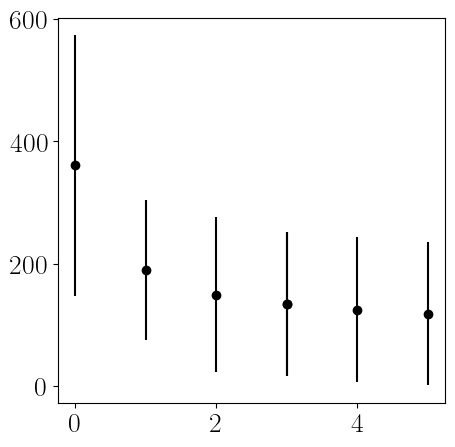

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.errorbar(df['number'], df['distance_initial_mean'], yerr=df['distance_initial_sigma_1'], fmt='o', color='black', label='Primary')
fig.show()